# Imports

In [0]:
import pandas as pd
import numpy as np
import tensorflow.compat.v2 as tf 
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sb

tf.version.VERSION

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0-rc3'

In [0]:
# matplotlib configuration

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (14, 6),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
# plt.rcParams.update(params)

In [0]:
# Function to show train history

def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# YELP
## Load data

In [0]:
path = "../data/yelp_labelled.txt"
yelpData = pd.read_csv(path, sep='\t', header=0, encoding="utf-8")
row_sizes = yelpData['SentimentText'].str.split().str.len()
yelpData['SentimentText'] = yelpData['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
yelpData

Words count: 10894


,SentimentText,Sentiment
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1
...,...,...
995,i think food should have flavor and texture an...,0
996,appetite instantly gone.,0
997,overall i was not impressed and would not go b...,0
998,"the whole experience was underwhelming, and i ...",0


## Preprocessing

In [0]:
df = yelpData
df['review_lenght'] = np.array(list(map(lambda x: len(x.split()), df['SentimentText'])))
median = df['review_lenght'].median()
mean = df['review_lenght'].mean()
_max_length = df['review_lenght'].max()

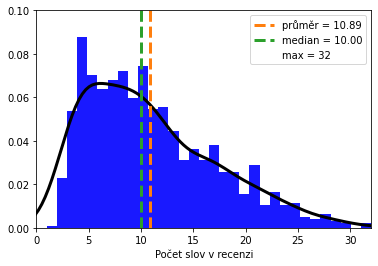

In [0]:
fig, ax = plt.subplots()
sb.distplot( df['review_lenght'],  bins=_max_length,
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=_max_length)
ax.set_xlabel('Počet slov v recenzi')
ymax = 0.1
plt.ylim(0, ymax)
ax.plot([mean, mean], [0, ymax], '--', label=f'průměr = {mean:.2f}', linewidth=3)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=3)
ax.plot([_max_length, _max_length], [0, ymax], '--', label=f'max = {_max_length}', linewidth=0)
# ax.set_title('Distribuce slov v recenzích', fontsize=20)
plt.legend()
plt.show()

In [0]:
# Tokenizing and padding

df = yelpData
max_dictionary_size = 2071
tokenizer = Tokenizer(num_words=max_dictionary_size)
tokenizer.fit_on_texts(df['SentimentText'])
list_tokenized_train = tokenizer.texts_to_sequences(df['SentimentText'])
max_length = _max_length
X_t = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y = yelpData['Sentiment']
print("Max dictionary size")
len(tokenizer.index_word)

2071

## LSTM

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
results = list()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        min_delta=0,
                                        patience=4,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)
## cros validation
for train, test in kfold.split(df['SentimentText'], y):
    model = keras.models.Sequential([
        keras.layers.Embedding(max_dictionary_size, 16, input_length=max_length),
        keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True)),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(16),
        keras.layers.Dense(1, activation="sigmoid")                                
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_t[train],y[train], batch_size=8, epochs=10,  validation_data=(X_t[test], y[test]), callbacks=[early_stopping])
    scores = model.evaluate(X_t[test], y[test])
    results.append(scores[1])
    fold += 1

print(f"Average accuracy = {sum(results)/fold * 100:0.2f} %")

Epoch 1/10
100/100 [==============================] - 1s 13ms/step - loss: 0.6924 - accuracy: 0.5312 - val_loss: 0.6859 - val_accuracy: 0.5700
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5887 - accuracy: 0.7387 - val_loss: 0.5154 - val_accuracy: 0.7650
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.2349 - accuracy: 0.9175 - val_loss: 0.4349 - val_accuracy: 0.8150
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0919 - accuracy: 0.9700 - val_loss: 0.6571 - val_accuracy: 0.7950
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0245 - accuracy: 0.9937 - val_loss: 0.9499 - val_accuracy: 0.7400
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0476 - accuracy: 0.9837 - val_loss: 0.6058 - val_accuracy: 0.8300
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.7244 - val_accuracy: 0.8150
Epoch

## CNN

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
results = list()
filters = 64
kernel_size = 3
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        min_delta=0,
                                        patience=4,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)
for train, test in kfold.split(df['SentimentText'], y):
    model = keras.models.Sequential([
        keras.layers.Embedding(max_dictionary_size, 16, input_length=max_length),
        keras.layers.Conv1D(filters, kernel_size, activation="relu"),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(64),
        keras.layers.Activation("relu"),
        keras.layers.Dense(1, activation="sigmoid")                                
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_t[train],y[train], batch_size=8, epochs=10,  validation_data=(X_t[test], y[test]), callbacks=[early_stopping])
    scores = model.evaluate(X_t[test], y[test])
    results.append(scores[1])
    fold += 1
print(f"Average accuracy = {sum(results)/fold * 100:0.2f} %")

Epoch 1/10
100/100 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5100 - val_loss: 0.6846 - val_accuracy: 0.5050
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.5992 - accuracy: 0.7600 - val_loss: 0.5124 - val_accuracy: 0.7900
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.2701 - accuracy: 0.9250 - val_loss: 0.5063 - val_accuracy: 0.7450
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9825 - val_loss: 0.5690 - val_accuracy: 0.7400
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.9987 - val_loss: 0.6135 - val_accuracy: 0.7600
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.6500 - val_accuracy: 0.7650
Epoch 00006: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.5088 - accuracy: 0.7900
Epoch 1/10
100/100 [===============

# IMDB
## Load data

In [0]:
path = "../data/imdb_50k.tsv"
imdbData = pd.read_csv(path, sep='\t', header=0, encoding="utf-8", doublequote=False, escapechar="\\")
imdbData = imdbData.drop(['id'], axis=1)
row_sizes = imdbData['SentimentText'].str.split().str.len()
imdbData['SentimentText'] = imdbData['SentimentText'].str.lower()
print(f"Words count: {pd.Series.sum(row_sizes)}")
imdbData

Words count: 11557842


,Sentiment,SentimentText
0,0,"a bit of a disappointing film, i'd say: the ac..."
1,0,"the acting was terrible, the cheesy, fake, che..."
2,1,"plenty has been written about mamet's ""the hou..."
3,1,"""journey to the far side of the sun"" (aka ""dop..."
4,1,i lived in that area (hoboken and jersey city)...
...,...,...
49995,1,"as a big dostoyevsky fan, i had always been di..."
49996,0,i didn't watch this show that much when i was ...
49997,1,for people who are first timers in film making...
49998,0,pumpkinhead was in itself a decent 80s horror ...


## Preprocessing

In [0]:
df = imdbData
df['review_lenght'] = np.array(list(map(lambda x: len(x.split()), df['SentimentText'])))
median = df['review_lenght'].median()
mean = df['review_lenght'].mean()
_max_length = df['review_lenght'].max()

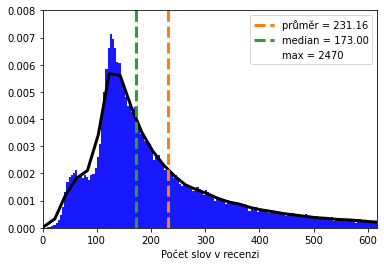

In [0]:
fig, ax = plt.subplots()
sb.distplot( df['review_lenght'],  bins=int(_max_length/4),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=_max_length/4)
ax.set_xlabel('Počet slov v recenzi')
ymax = 0.008
plt.ylim(0, ymax)
ax.plot([mean, mean], [0, ymax], '--', label=f'průměr = {mean:.2f}', linewidth=3)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=3)
ax.plot([_max_length, _max_length], [0, ymax], '--', label=f'max = {_max_length}', linewidth=0)
# ax.set_title('Distribuce slov v recenzích', fontsize=20)
plt.legend()
plt.show()

In [0]:
# Tokenizing and padding

max_dictionary_size = 10000
tokenizer = Tokenizer(num_words=max_dictionary_size)
tokenizer.fit_on_texts(df['SentimentText'])
list_tokenized_train = tokenizer.texts_to_sequences(df['SentimentText'])
max_length = 400
X_t = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
y = imdbData['Sentiment']
print("Max dictionary size")
len(tokenizer.index_word)

124264

## LSTM

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
results = list()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        min_delta=0,
                                        patience=3,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)

for train, test in kfold.split(df['SentimentText'], y):
    print(f"******* Fold {fold + 1} ***********")
    model = keras.models.Sequential([
        keras.layers.Embedding(max_dictionary_size, 16, input_length=max_length),
        keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True)),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(16),
        keras.layers.Dense(1, activation="sigmoid")                                
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_t[train],y[train], batch_size=64, epochs=10, validation_data=(X_t[test], y[test]), callbacks=[early_stopping])
    scores = model.evaluate(X_t[test], y[test])
    results.append(scores[1])
    fold += 1
print(f"Average accuracy = {sum(results)/fold * 100:0.2f} %")

******* Fold 1 ***********
Epoch 1/10
625/625 [==============================] - 24s 38ms/step - loss: 0.3694 - accuracy: 0.8245 - val_loss: 0.2823 - val_accuracy: 0.8842
Epoch 2/10
625/625 [==============================] - 24s 38ms/step - loss: 0.2026 - accuracy: 0.9209 - val_loss: 0.2696 - val_accuracy: 0.8844
Epoch 3/10
625/625 [==============================] - 23s 38ms/step - loss: 0.1566 - accuracy: 0.9420 - val_loss: 0.2670 - val_accuracy: 0.8960
Epoch 4/10
625/625 [==============================] - 24s 38ms/step - loss: 0.1225 - accuracy: 0.9565 - val_loss: 0.3266 - val_accuracy: 0.8763
Epoch 5/10
625/625 [==============================] - 24s 38ms/step - loss: 0.0948 - accuracy: 0.9678 - val_loss: 0.3205 - val_accuracy: 0.8885
Epoch 6/10
625/625 [==============================] - 23s 38ms/step - loss: 0.0692 - accuracy: 0.9771 - val_loss: 0.3862 - val_accuracy: 0.8832
Epoch 00006: early stopping
313/313 [==============================] - 4s 12ms/step - loss: 0.2667 - accuracy

## CNN

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
results = list()
filters = 64
kernel_size = 3

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        min_delta=0,
                                        patience=3,
                                        verbose=1,
                                        mode='auto',
                                        restore_best_weights=True)

for train, test in kfold.split(df['SentimentText'], y):
    print(f"******* Fold {fold + 1} ***********")
    model = keras.models.Sequential([
        keras.layers.Embedding(max_dictionary_size, 16, input_length=max_length),
        keras.layers.Conv1D(filters, kernel_size, activation="relu"),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(64),
        keras.layers.Activation("relu"),
        keras.layers.Dense(1, activation="sigmoid")                                
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_t[train],y[train], batch_size=32, epochs=10, validation_data=(X_t[test], y[test]), callbacks=[early_stopping])
    scores = model.evaluate(X_t[test], y[test])
    results.append(scores[1])
    fold += 1
print(f"Average accuracy = {sum(results)/fold * 100:0.2f} %")

******* Fold 1 ***********
Epoch 1/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3794 - accuracy: 0.8219 - val_loss: 0.2620 - val_accuracy: 0.8913
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2044 - accuracy: 0.9191 - val_loss: 0.2562 - val_accuracy: 0.8937
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1292 - accuracy: 0.9550 - val_loss: 0.2746 - val_accuracy: 0.8956
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0706 - accuracy: 0.9771 - val_loss: 0.3290 - val_accuracy: 0.8922
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0356 - accuracy: 0.9899 - val_loss: 0.3950 - val_accuracy: 0.8886
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.4755 - val_accuracy: 0.8892
Epoch 00006: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.2746 - accuracy: